In [1]:
using DrWatson
@quickactivate
include(srcdir("main.jl"))
using DataFrames
using DataFramesMeta
using AlgebraOfGraphics

In [4]:
dfs = collect_results(datadir("simulations"));

┌ Info: Scanning folder /Users/zijin/projects/ion_scattering_by_SWD/data/simulations for result files.
└ @ DrWatson /Users/zijin/.julia/packages/DrWatson/8XYbJ/src/result_collection.jl:117
┌ Info: Added 8 entries.
└ @ DrWatson /Users/zijin/.julia/packages/DrWatson/8XYbJ/src/result_collection.jl:193


In [5]:
cos_pitch_angle(u, α, β) = cos_pitch_angle(u, RD_B_field(u, α, β))

df = vcat(dfs[:,:result]...);

@chain df begin
    @rtransform!(:u1 = :u[end])
    @rtransform!(
        :w0 = cos_pitch_angle(:u0, :α, :β),
        :w1 = cos_pitch_angle(:u1, :α, :β)
    )
    @transform!(
        :Δw = :w1 .- :w0,
    )
end;

In [6]:
rename_value(v, s::Symbol; digits=2) = v => "$(s) = $(round(v, digits=digits))"

syms = [:α, :β, :v]

α_map, β_map, v_map = map(syms) do s
    vals = unique(dfs[!, s]) |> sort
    s => renamer(rename_value.(vals, s))
end

Δw_map = :Δw

:Δw

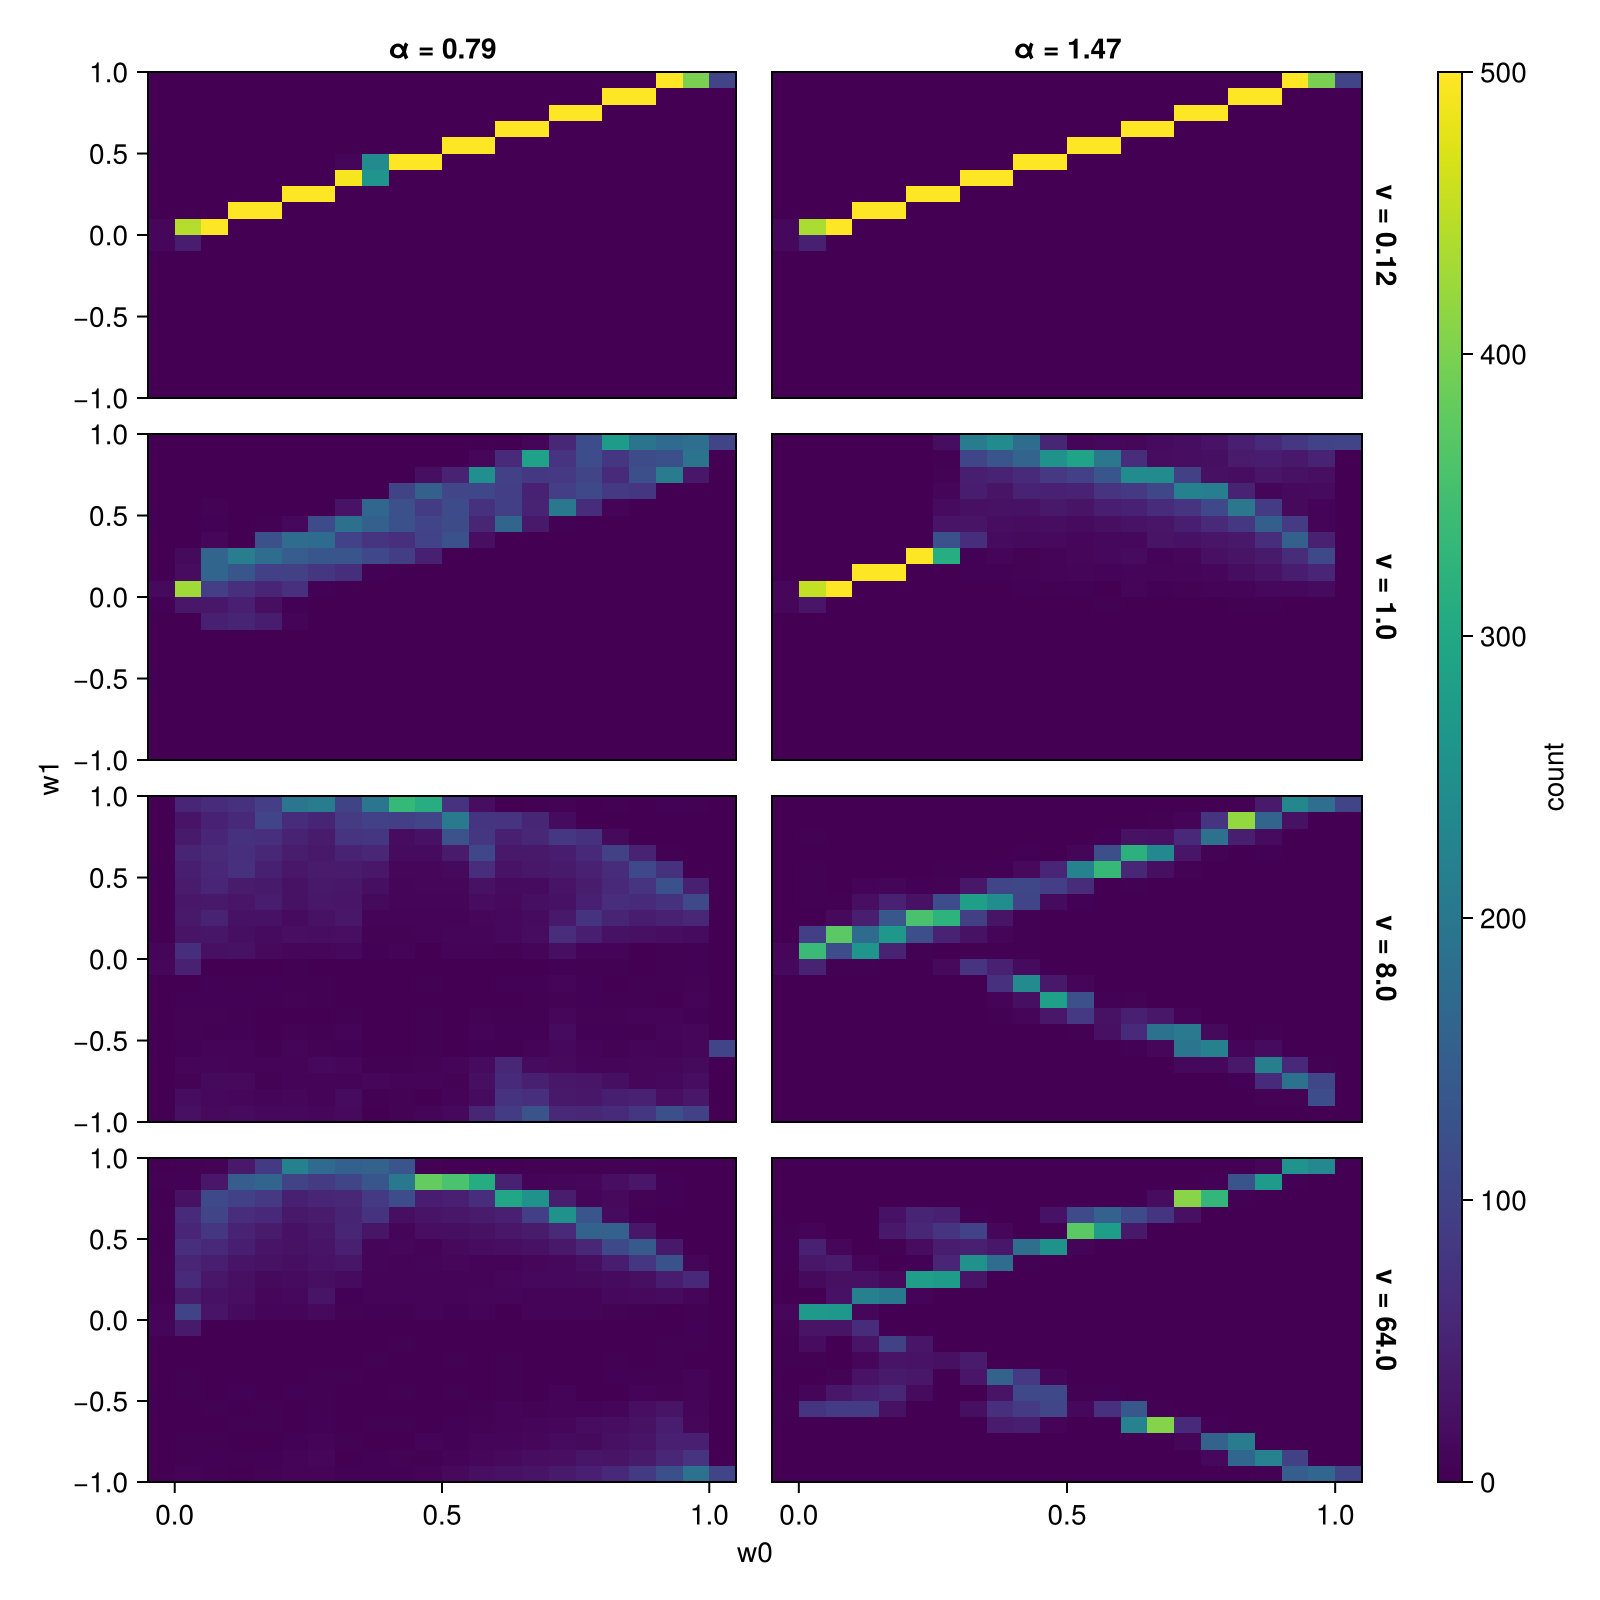

In [7]:
function pa_pair_plot(layer; kwargs...)
    plt = layer * mapping(:w0, :w1;) * histogram(bins=32) 
    # axis=(; colorscale=log10)
    axis = (;)
    draw(plt; axis=axis, kwargs...)
end
pa_pair_plot(df::AbstractDataFrame) = pa_pair_plot(data(df))

figure = (size = (800, 800),)

layer = data(df) * mapping(col = α_map, row = v_map)
pa_pair_plot(layer, figure = figure)

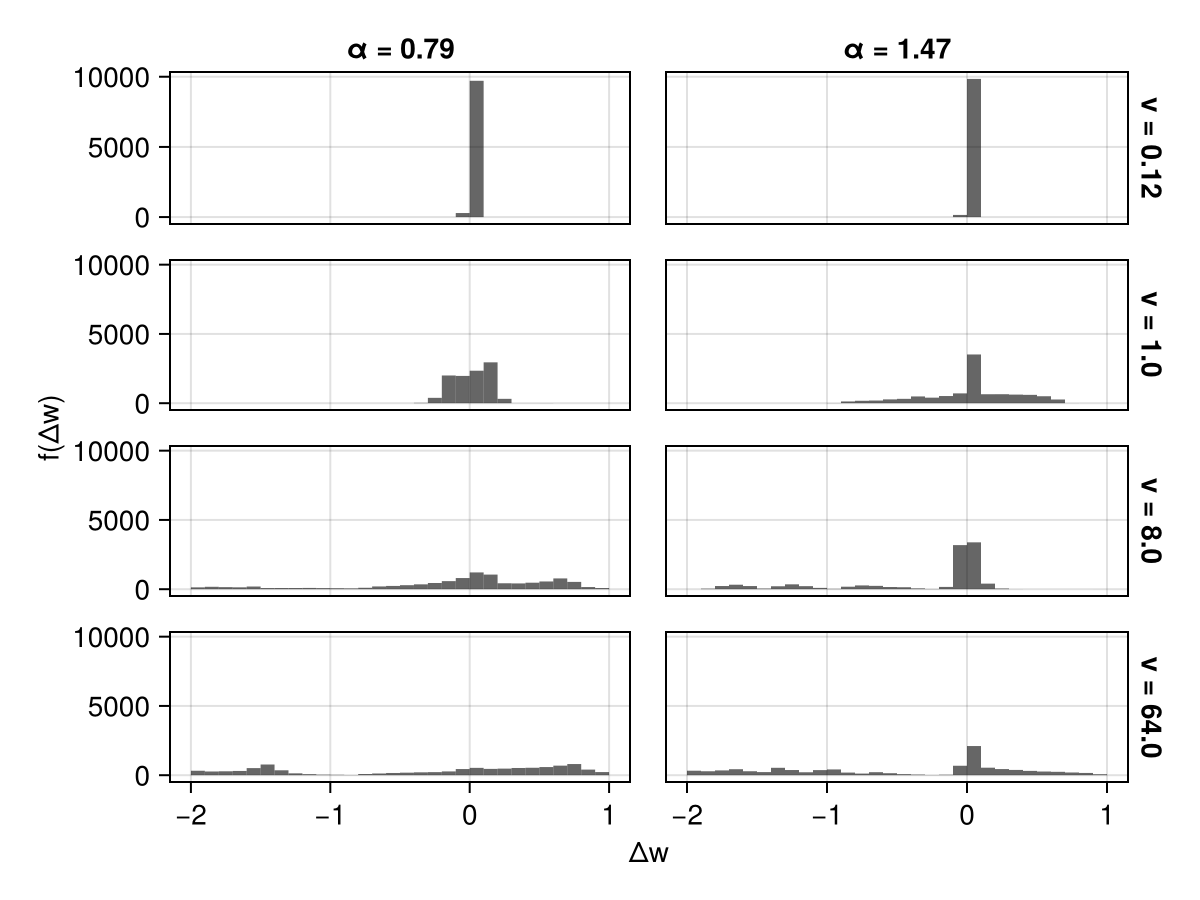

In [69]:
"""
Plot the distribution of pitch-angle cosine variation
"""
function pa_diff_plot(layer; kwargs...)
    plt = layer * mapping(:Δw) * histogram(bins=32) 
    axis=(; xlabel="Δw", ylabel="f(Δw)")
    draw(plt; axis=axis, kwargs...)
end

pa_diff_plot(layer)

In [ ]:
# sols, sol_field = sim(d)
# Step 4: Visualization
# plot_trajectory(d) = plot_trajectory(sim(d)...)
# f = plot_trajectory(sols, sol_field)
# plot_trajectory(d)

In [13]:
function d_cos_pitch_angle(sol)
    return cos_pitch_angle(sol, 1) - cos_pitch_angle(sol, length(sol))
end

function d_cos_pitch_angle(sol::EnsembleSolution)
    return map(sol) do s
        d_cos_pitch_angle(s)
    end
end

d_cos_pitch_angle (generic function with 2 methods)

In [15]:
df[!, :Δw] = d_cos_pitch_angle.(df[!, :result]);

MethodError: MethodError: objects of type JLD2.ReconstructedStatic{Symbol("Field{false,JLD2.ReconstructedStatic{Symbol(\"#119#122{Float64,Float64}\"), (:α, :β), Tuple{Float64, Float64}}}"), (:field_function,), Tuple{JLD2.ReconstructedStatic{Symbol("#119#122{Float64,Float64}"), (:α, :β), Tuple{Float64, Float64}}}} are not callable

## Understand trajectory

In [ ]:
d = dicts[end]
sol = sim(d; Nw=10, Nϕ=10)

plot(sol, idxs = (0, 1), transparency = 0.6)
plot(sol, idxs = (0, 2), transparency = 0.6, color = :red, )
plot(sol, idxs = (0, 3), transparency = 0.6, label = "z")
current_figure()

In [ ]:
summ = EnsembleSummary(sol)
plot(summ, alpha = 0.5, idxs = (3))

band(summ, idxs = (3), color = :red)